<a href="https://colab.research.google.com/github/carlosEcl06/informaticsMedImages/blob/main/colabGrupo2aval3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RIB0107 - Fundamentos de Informática em Imagens Médicas: Avaliação Parcial 3
## GRUPO 2: Carlos, Gabriel, Guilherme, Kathley, Raul, Victor, Vinícius e Vitor
### Construção e treinamento de um modelo de classificação baseado em rede neural convolucional para a diferenciação de fraturas vertebrais por compressão benignas e malignas

### 1. Importação de bibliotecas

In [7]:
# Se ainda não instalado, descomentar e rodar:
! pip install pynrrd

In [8]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import string
import random
from tensorflow import keras

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Importação da base de dados
Notas:
A base foi organizada pela Informata Biomédica (ex-aluna de nosso curso) Natália Santana Chiari Correia, como parte de sua pesquisa de doutorado no Programa de Pós-Graduação em Clínica Médica da FMRP, sob orientação dos Profs. Paulo e Marcello.

ATENÇÃO: Essa base é para uso exclusivo na disciplina e não pode ser compartilhada ou utilizada para outras finalidades sem autorização específica dos professores ou da sua organizadora.

A base contém:

- Os exames originais em formato DICOM anonimizados.
- Um arquivo .xlsx com a classe de cada paciente, o sexo, a idade e quais corpos vertebrais foram segmentados.
- Outras duas pastas além dos exames originais: uma com as imagens requantizadas para 256 níveis de tons de cinza no formato .nrrd e outra com os arquivos de segmentação no formato .seg.nrrd.

In [10]:
#caminhoCarlos="/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPrático3/dados"
#caminhoGuilherme="/content/Trabalho3/dados"
#caminhokat = "/content/drive/MyDrive/TrabalhoPratico3/dados"
#caminhoFulano="</content/drive/<seu_caminho>"

# Adicione acima o seu caminho para a pasta dados, e antes de executar essa célula copie ele para o comando abaixo
! cp -r '/content/drive/MyDrive/USP/Disciplinas/4º Período/RIB0107 - Fundamentos de Informática em Imagens Médicas/TrabalhoPratico3/dados' '/content/'

Favor, verificar se a pasta dados apareceu na barra de arquivos do colab

In [11]:
! unzip '/content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip'
! unzip '/content/dados/Cópia de 2-Rescaled_256_NRRD-20220915T191517Z-001.zip'
! unzip '/content/dados/Cópia de 3-Segmentation_NRRD-20220916T175039Z-001.zip'

Archive:  /content/dados/Cópia de 1-Original_Anon_Dicom-20220915T191018Z-001.zip
  inflating: 1-Original_Anon_Dicom/P18/I00008.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00012.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00010.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00007.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00004.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00006.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00009.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00003.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00003.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00008.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P30/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00010.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P18/I00011.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00002.dcm.dcm  
  inflating: 1-Original_Anon_Dicom/P1/I00005.dcm.dcm  
  inflating: 1-Original_An

As imagens da base agora se encontram distribuídas em três pastas presentes no diretório "content" do colab

In [12]:
# Leitura da tabela excel contendo informações dos pacientes
patientsTable = pd.read_excel('/content/dados/Cópia de Patients.xlsx')

### 3. Visualização inicial dos dados

In [13]:
patientsTable.head(5)

,Id,Age at the exam,Gender,Class,Segmented Vertebra
0,P1,67,F,benign,L1
1,P2,61,F,benign,L1/L3/L5
2,P3,65,M,benign,L1
3,P4,84,M,benign,L3
4,P5,78,F,benign,L1/L4


In [14]:
patientsTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  91 non-null     object
 1   Age at the exam     91 non-null     int64 
 2   Gender              91 non-null     object
 3   Class               91 non-null     object
 4   Segmented Vertebra  91 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.7+ KB


O DataFrame patientsTable possui 91 entradas e 5 colunas. As colunas "Id" e "Gender" contêm strings, enquanto as colunas "Age at the exam" e "Class" contêm números inteiros. Todas as colunas não têm valores nulos, o que significa que todas as entradas nas colunas possuem valores.

Para visualização inicial das imagens, foram utilizados os seguintes sites:

[Visualizador de imagens DICOM (extenção .dcm) gratuito na web](https://www.imaios.com/br/imaios-dicom-viewer)

[Conversor de arquivos "near raw" (.nrrd) para .dcm](https://www.onlineconverter.com/nrrd-to-dicom)

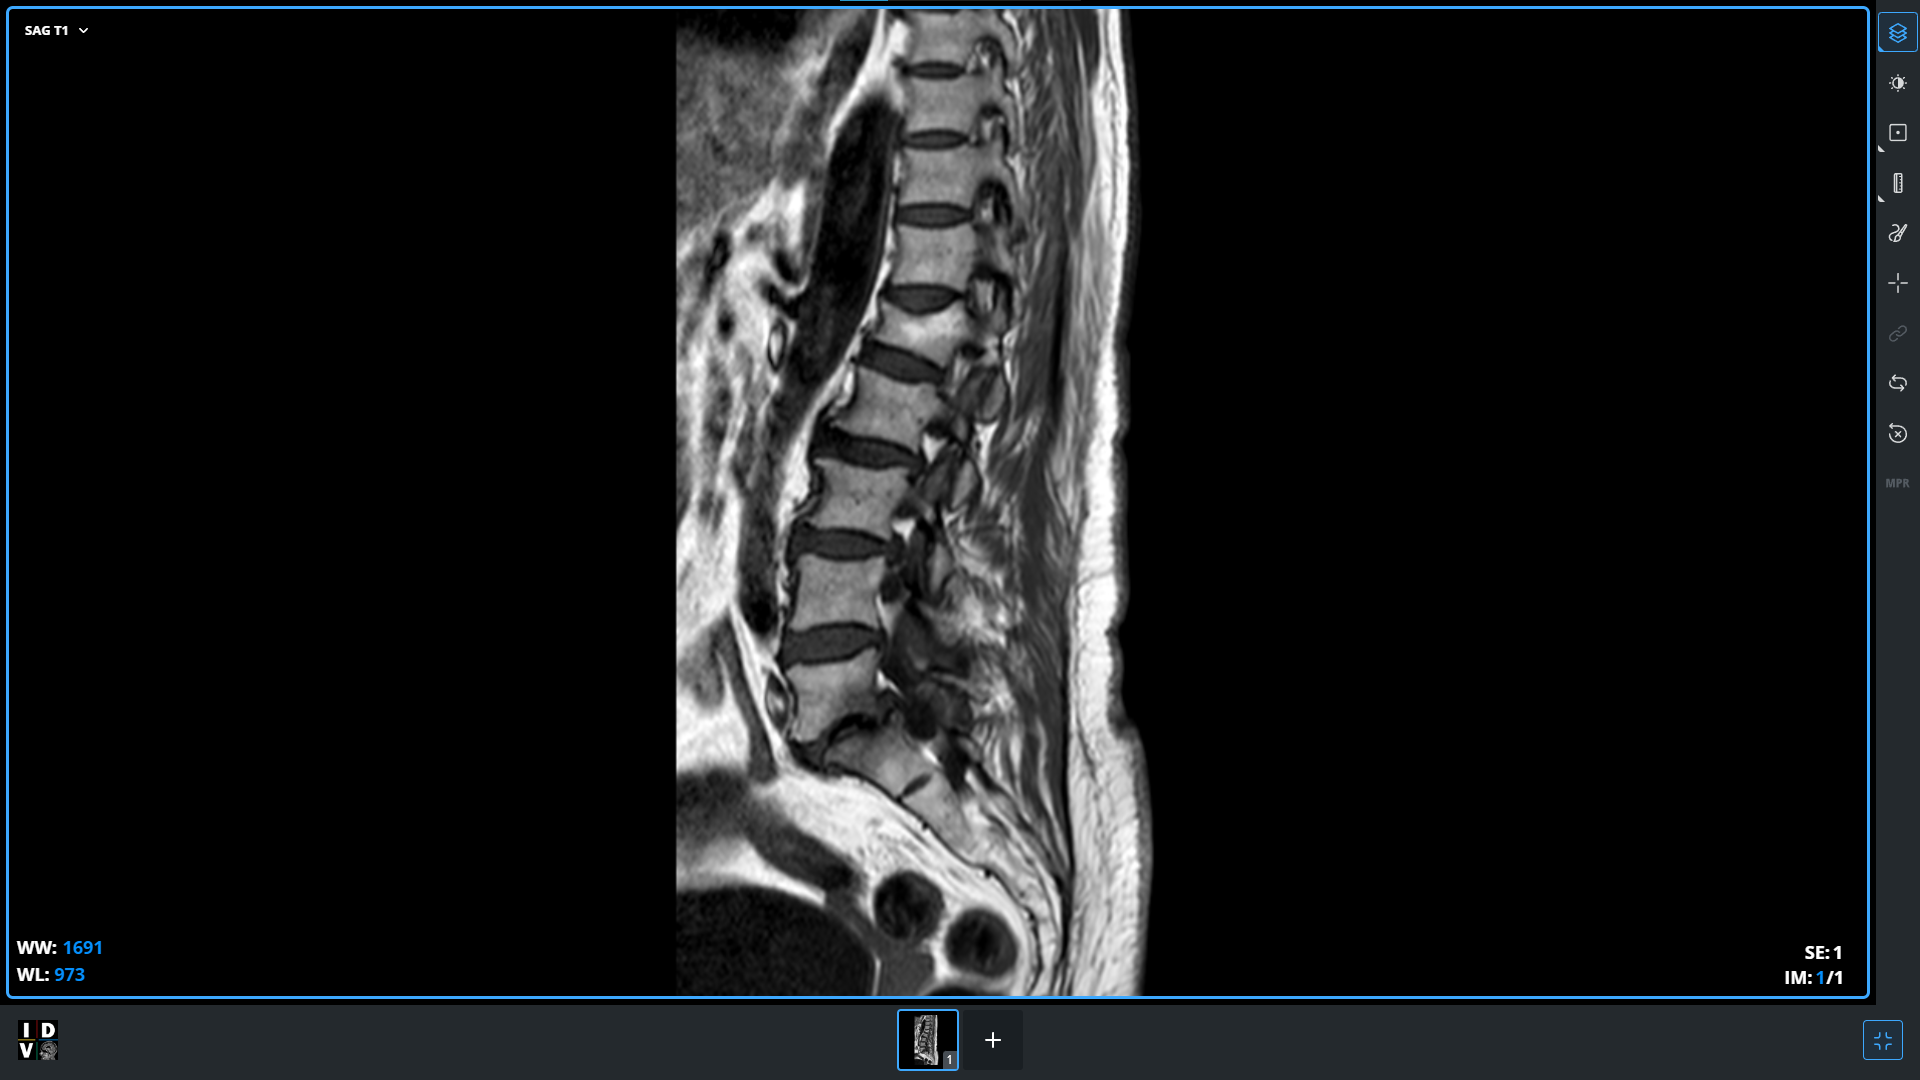
/content/1-Original_Anon_Dicom/P1/I00005.dcm.dcm aberta no visualizador web IMAIOS

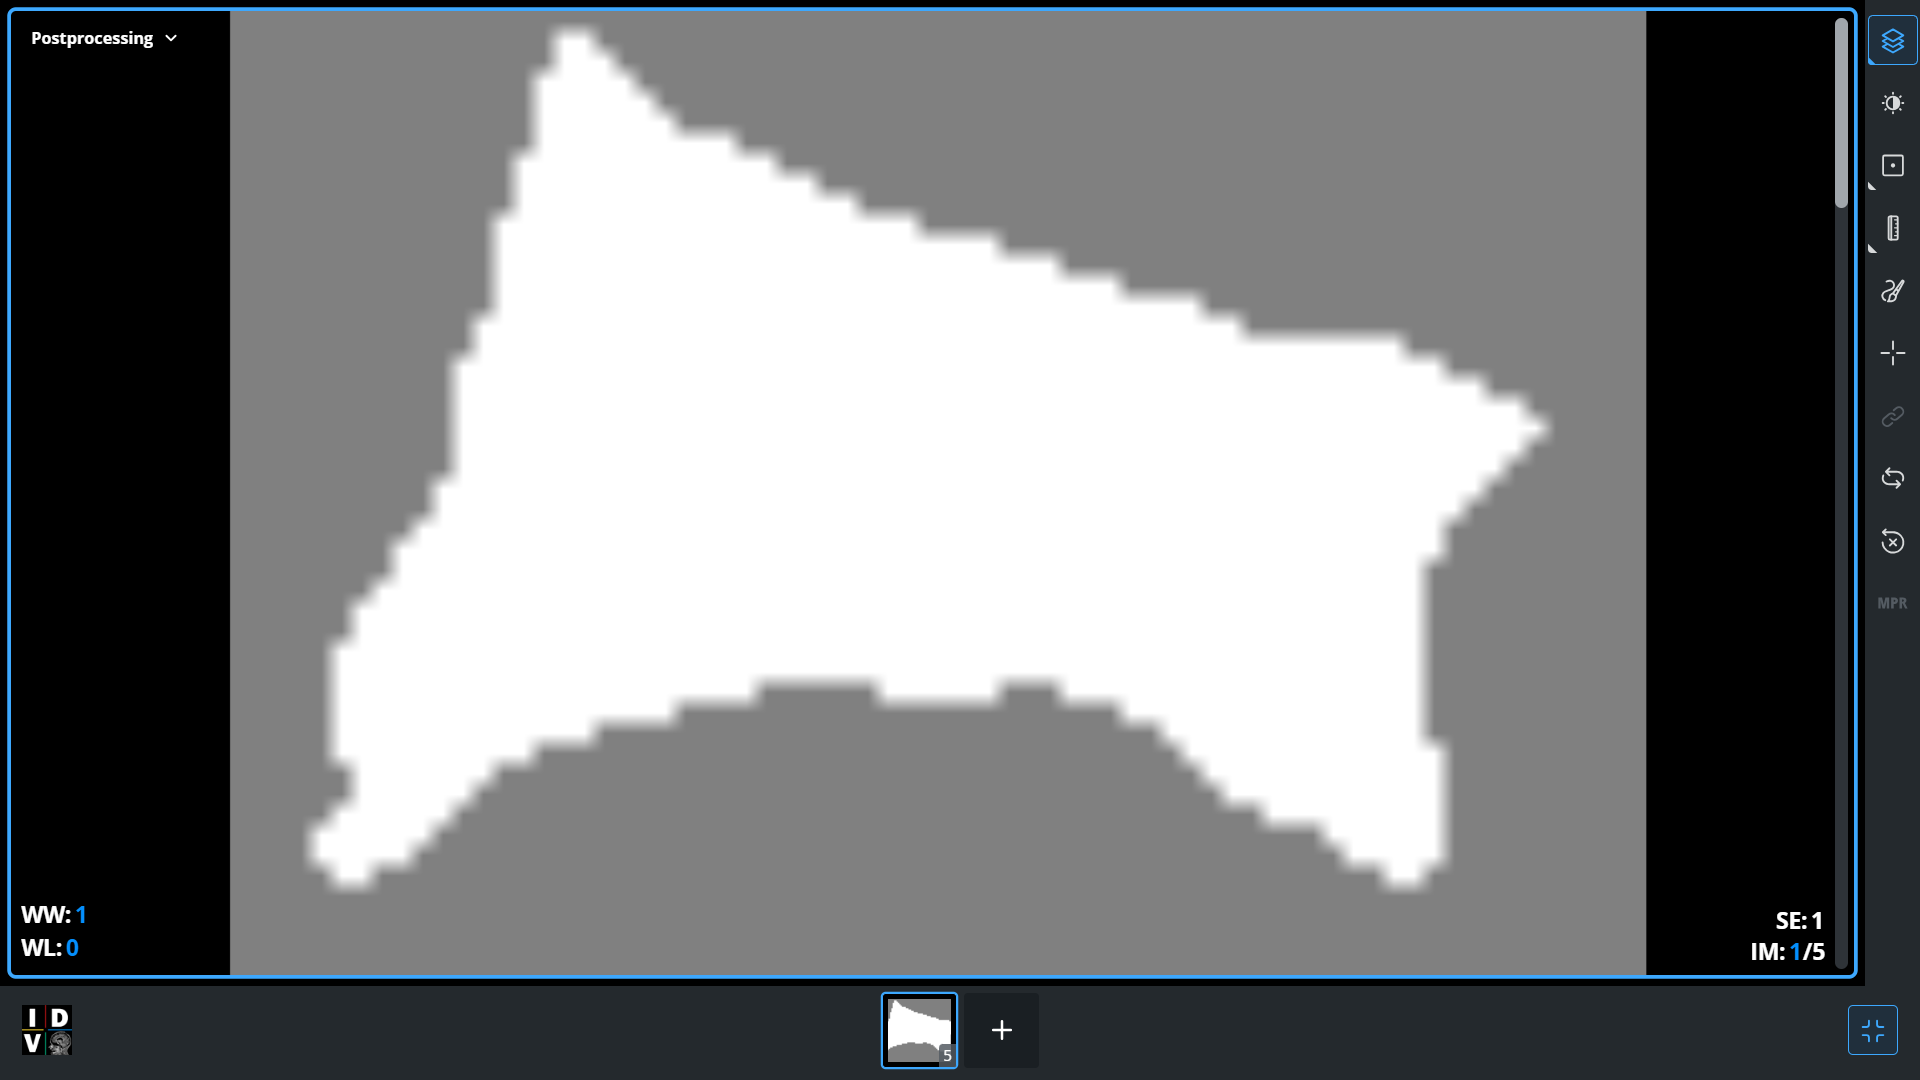
/content/3-Segmentation_NRRD/P1L1.seg.nrrd aberta no visualizador IMAIOS após conversão no Online Converter. É exibida a primeira de 5 fatias

Chaves do dicionário de máscaras: 'P1L1' = Paciente 1: Vértebra L1

Chave do dicionário de imagens: Apenas o paciente. ex: 'P1'

### 4. Pré-pocessamento das imagens. Utilização das máscaras.
#### 4.1 Preparo dos Dicionários

Máscaras

In [15]:
path_mask = '/content/3-Segmentation_NRRD/' # Caminho para as máscaras
os.chdir(path_mask)

In [16]:
masks = {}  # Cria um dicionário vazio chamado "masks"
header_mask = {}  # Cria um dicionário vazio chamado "header_mask"

In [17]:
seg_folder = '3-Segmentation_NRRD' # Nome do diretório contendo as segmentações
seg_sufix = '.seg.nrrd' # Extensão dos arquivos de segmentação

In [18]:
# Loop de leitura das segmentações
for file in os.listdir():
    if file.endswith(seg_sufix):
        file_path = path_mask + file
        # Encontre os índices das substrings 'seg_folder' e 'seg_sufix'
        segFolderIndex = file_path.index(seg_folder)
        segSufixIndex = file_path.index(seg_sufix)
        keyname = file_path[segFolderIndex + len(seg_folder):segSufixIndex]  # Criação da chave
        keyname = keyname.lstrip('/')  # Remove a barra da frente (se existir)
        # Leitura dos arquivos .nrrd
        masks[keyname], header_mask[keyname] = nrrd.read(file_path)

In [19]:
masks.keys()

dict_keys(['P45L1', 'P1L1', 'P84L3', 'P4L3', 'P74L2', 'P91L4', 'P62L4', 'P29L1', 'P81L1', 'P77L4', 'P30L1', 'P85L1', 'P10L5', 'P6L1', 'P20L1', 'P88L4', 'P35L5', 'P10L1', 'P5L1', 'P71L2', 'P35L2', 'P33L1', 'P8L3', 'P49L1', 'P24L2', 'P48L3', 'P15L2', 'P63L4', 'P42L2', 'P75L1', 'P26L4', 'P69L3', 'P24L3', 'P16L1', 'P57L1', 'P51L2', 'P79L4', 'P46L4', 'P35L1', 'P43L4', 'P3L1', 'P55L3', 'P40L4', 'P86L2', 'P67L3', 'P34L1', 'P2L5', 'P14L3', 'P51L5', 'P41L4', 'P65L1', 'P37L4', 'P31L1', 'P10L3', 'P24L5', 'P58L3', 'P76L5', 'P70L3', 'P19L1', 'P56L2', 'P26L1', 'P89L5', 'P45L3', 'P35L4', 'P9L2', 'P60L2', 'P6L5', 'P7L1', 'P49L5', 'P2L1', 'P39L5', 'P41L5', 'P14L1', 'P13L2', 'P38L4', 'P35L3', 'P18L4', 'P53L1', 'P83L3', 'P44L3', 'P42L1', 'P80L5', 'P17L3', 'P15L4', 'P61L1', 'P78L2', 'P38L5', 'P12L2', 'P68L1', 'P42L5', 'P11L2', 'P16L2', 'P32L4', 'P27L4', 'P22L2', 'P23L2', 'P26L2', 'P38L3', 'P50L5', 'P28L4', 'P59L4', 'P36L2', 'P25L1', 'P73L4', 'P55L2', 'P6L3', 'P72L1', 'P42L4', 'P54L1', 'P8L4', 'P32L1', 'P5

Segmentation mask key: P90L4


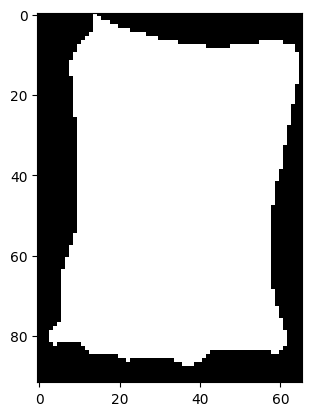

In [20]:
# Testando leitura - Exibindo imagem aleatória
rand_key = random.choice(list(masks.keys()))
plt.imshow(masks[rand_key][:,:,0], cmap='gray')
print('Segmentation mask key:',rand_key)

Imagens originais (versões rescaled)

In [21]:
path_image = '/content/2-Rescaled_256_NRRD/' # Caminho para as imagens
os.chdir(path_image)

In [22]:
images = {}  # Cria um dicionário vazio chamado "images"
header_image = {}  # Cria um dicionário vazio chamado "header_image"

In [23]:
img_folder = '2-Rescaled_256_NRRD' # Nome do diretório contendo as imagens
img_sufix = '.nrrd' # Extensão dos arquivos de imagem

In [24]:
# Loop de leitura das imagens
for file in os.listdir():
    if file.endswith(img_sufix):
        file_path = path_image + file
        # Encontre os índices das substrings 'img_folder' e 'img_sufix'
        imgFolderIndex = file_path.index(img_folder)
        imgSufixIndex = file_path.index(img_sufix)
        keyname = file_path[imgFolderIndex + len(img_folder):imgSufixIndex]  # Criação da chave
        keyname = keyname.lstrip('/')  # Remove a barra da frente (se existir)
        # Leitura dos arquivos .nrrd
        images[keyname], header_image[keyname] = nrrd.read(file_path)

In [25]:
images.keys()

dict_keys(['P28', 'P59', 'P54', 'P82', 'P57', 'P24', 'P13', 'P56', 'P90', 'P37', 'P76', 'P18', 'P32', 'P16', 'P58', 'P4', 'P23', 'P3', 'P63', 'P1', 'P51', 'P91', 'P29', 'P39', 'P31', 'P87', 'P19', 'P81', 'P83', 'P75', 'P62', 'P27', 'P84', 'P35', 'P17', 'P12', 'P66', 'P70', 'P36', 'P7', 'P77', 'P69', 'P80', 'P64', 'P60', 'P20', 'P53', 'P15', 'P73', 'P22', 'P50', 'P45', 'P34', 'P9', 'P47', 'P52', 'P67', 'P88', 'P26', 'P79', 'P55', 'P89', 'P25', 'P14', 'P2', 'P42', 'P6', 'P68', 'P5', 'P72', 'P86', 'P74', 'P43', 'P65', 'P85', 'P21', 'P71', 'P41', 'P78', 'P33', 'P30', 'P46', 'P11', 'P40', 'P61', 'P48', 'P49', 'P38', 'P8', 'P44', 'P10'])

Original image key: P27


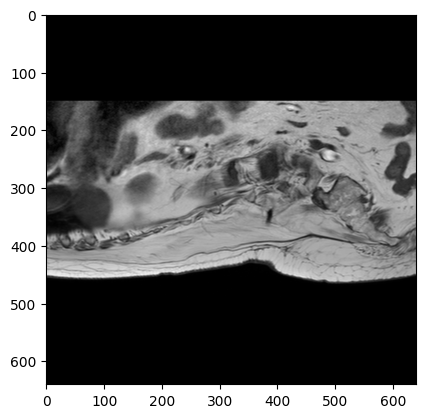

In [26]:
# Testando leitura - Exibindo imagem aleatória
rand_key = random.choice(list(images.keys()))
plt.imshow(images[rand_key][:,:,0], cmap='gray')
print('Original image key:',rand_key)

#### 4.2 Explorando os arquivos

In [27]:
for key in masks:
  print(masks[key][:,:].shape)

(113, 61, 5)
(70, 48, 5)
(82, 53, 6)
(82, 50, 5)
(104, 76, 6)
(120, 80, 6)
(62, 38, 6)
(84, 68, 5)
(84, 73, 4)
(75, 74, 7)
(123, 103, 5)
(75, 64, 5)
(102, 76, 9)
(112, 65, 5)
(77, 64, 5)
(115, 81, 7)
(87, 90, 6)
(111, 79, 9)
(97, 78, 5)
(103, 76, 5)
(87, 66, 6)
(97, 72, 5)
(89, 46, 6)
(74, 48, 6)
(106, 72, 7)
(113, 63, 5)
(115, 102, 5)
(91, 60, 5)
(110, 50, 6)
(76, 44, 6)
(134, 77, 7)
(119, 84, 7)
(125, 68, 8)
(81, 64, 4)
(76, 62, 6)
(115, 85, 6)
(91, 63, 6)
(117, 98, 6)
(92, 63, 6)
(114, 95, 7)
(110, 86, 6)
(72, 47, 5)
(89, 53, 7)
(89, 59, 4)
(91, 55, 8)
(81, 55, 6)
(72, 71, 6)
(97, 32, 7)
(97, 79, 7)
(101, 73, 6)
(78, 49, 5)
(111, 76, 6)
(67, 48, 6)
(131, 90, 9)
(108, 93, 8)
(79, 56, 4)
(93, 80, 8)
(76, 54, 5)
(104, 92, 7)
(77, 53, 6)
(116, 71, 6)
(87, 68, 6)
(120, 63, 6)
(88, 77, 6)
(88, 50, 6)
(113, 91, 8)
(118, 65, 6)
(102, 69, 5)
(77, 69, 7)
(71, 51, 6)
(91, 84, 6)
(98, 90, 6)
(70, 42, 6)
(81, 51, 7)
(110, 93, 7)
(87, 74, 6)
(120, 64, 5)
(108, 87, 5)
(81, 67, 7)
(105, 78, 7)
(99,

In [28]:
for key in images:
  print(images[key][:,:].shape)

(864, 864, 12)
(640, 640, 12)
(640, 640, 12)
(704, 704, 14)
(640, 640, 15)
(864, 864, 14)
(640, 640, 14)
(640, 640, 12)
(640, 640, 14)
(960, 960, 12)
(640, 640, 14)
(864, 864, 12)
(640, 640, 14)
(768, 768, 12)
(800, 800, 14)
(640, 640, 14)
(640, 640, 12)
(896, 896, 12)
(768, 768, 12)
(640, 640, 14)
(864, 864, 12)
(800, 800, 12)
(512, 512, 12)
(864, 864, 12)
(640, 640, 14)
(768, 768, 12)
(768, 768, 12)
(640, 640, 14)
(704, 704, 14)
(640, 640, 12)
(384, 384, 12)
(640, 640, 14)
(640, 640, 14)
(864, 864, 12)
(704, 704, 14)
(864, 864, 12)
(640, 640, 14)
(640, 640, 14)
(960, 960, 12)
(864, 864, 12)
(704, 704, 14)
(640, 1750, 12)
(640, 640, 12)
(640, 640, 14)
(864, 864, 12)
(640, 640, 12)
(864, 864, 12)
(864, 864, 12)
(768, 768, 12)
(704, 704, 14)
(864, 864, 12)
(880, 880, 12)
(640, 640, 14)
(640, 640, 14)
(896, 896, 12)
(768, 768, 12)
(704, 704, 14)
(864, 864, 12)
(864, 864, 12)
(672, 672, 14)
(640, 640, 12)
(704, 704, 15)
(864, 864, 12)
(640, 640, 14)
(640, 640, 14)
(768, 768, 12)
(864, 864

In [29]:
# O atributo 'Segmentation_ReferenceImageExtentOffset' informa as coordenadas da máscara em relação à imagem original
header_mask['P1L1']

OrderedDict([('type', 'unsigned char'),
             ('dimension', 3),
             ('space', 'right-anterior-superior'),
             ('sizes', array([70, 48,  5])),
             ('space directions',
              array([[ 0.        , -0.52325583,  0.        ],
                     [-0.02111105,  0.        , -0.52282978],
                     [ 3.99674291, -0.        , -0.1613822 ]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('encoding', 'gzip'),
             ('space origin',
              array([  8.12124536,   3.24763441, 181.8327767 ])),
             ('measurement frame',
              array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])),
             ('Segment0_Color', '0.501961 0.682353 0.501961'),
             ('Segment0_ColorAutoGenerated', '1'),
             ('Segment0_Extent', '0 69 0 47 0 4'),
             ('Segment0_ID', 'Segment_1'),
             ('Segment0_Name', 'Segment_1'),
             ('Segment0_Nam

#### 4.3 Seleção da região de interesse das imagens

In [30]:
# Função "zoom"
def submatrix(arr):
    x, y = np.nonzero(arr)
    return arr[x.min():x.max()+1, y.min():y.max()+1]

# Função que "posiciona" a máscara sobre a original de acordo com o header e deixa o resto preto
def segmentarImagem(mask,header,image):

    #mapeia a referência da imagem original de string para int
    refImY,refImX,refImZ = list(map(int, header['Segmentation_ReferenceImageExtentOffset'].split()))

    #pegando o tamanho da máscara
    sizeMaskY, sizeMaskX = mask[:,:,2].shape

    #inicializando matriz segmentos
    segmentos = np.zeros(image.shape[0:2])

    #colocando a máscara dentro da matriz segmentos
    segmentos[refImY:refImY+sizeMaskY,refImX:refImX+sizeMaskX] = segmentos[refImY:refImY+sizeMaskY,refImX:refImX+sizeMaskX] + mask[:,:,0]

    #multiplicando a imagem original pela máscara
    segmentos = segmentos*image[:,:,refImZ+2]

    return submatrix(segmentos)


In [31]:
# Criação de um dicionário vazio
segmentos = {}

In [32]:
for imgkey in list(images.keys()):
  for maskkey in list(masks.keys()):
    if len(maskkey) == 4 and len(imgkey) == 2:
      if maskkey[0:2] == imgkey:
        segmentos[maskkey] = segmentarImagem(masks[maskkey], header_mask[maskkey], images[imgkey])
    if len(maskkey) == 5 and len(imgkey) == 3:
      if maskkey[0:3] == imgkey:
        segmentos[maskkey] = segmentarImagem(masks[maskkey], header_mask[maskkey], images[imgkey])

In [33]:
segmentos

{'P28L4': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'P59L4': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [25., 24., 23., ..., 59., 39., 30.],
        [ 0., 15., 18., ..., 64., 41., 31.],
        [ 0.,  0.,  0., ..., 59., 42.,  0.]]),
 'P54L1': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'P82L2': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0.,

Segmented image key: P25L1


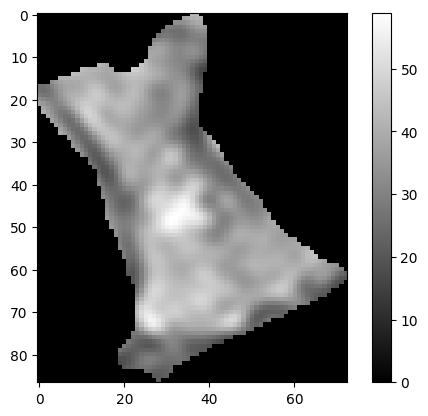

In [34]:
rand_key = random.choice(list(segmentos.keys()))
plt.imshow(segmentos[rand_key],cmap='gray')
plt.colorbar()
print('Segmented image key:',rand_key)

In [35]:
len(segmentos)

130

### 5. Tratamento dos dados

In [36]:
dtypes = [('segmento', np.ndarray), ('label', pd.core.series.Series), ('Id', pd.core.series.Series)]

seg_wLabs = np.empty((130), dtype=dtypes)

seg_wLabs

array([(None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, None),
       (None, None, None), (None, None, None), (None, None, No

In [37]:
i=0
for patient_id in patientsTable['Id']:
  for segkey in list(segmentos.keys()):
    if len(segkey) == 4 and len(patient_id) == 2:
      if segkey[0:2] == patient_id:
        index = patientsTable[patientsTable['Id'] == patient_id].index[0]
        seg_wLabs[i] = segmentos[segkey], patientsTable['Class'][index], patientsTable['Id'][index]
        i+=1
    if len(segkey) == 5 and len(patient_id) == 3:
      if segkey[0:3] == patient_id:
        index = patientsTable[patientsTable['Id'] == patient_id].index[0]
        seg_wLabs[i] = segmentos[segkey], patientsTable['Class'][index], patientsTable['Id'][index]
        i+=1
seg_wLabs

array([(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              ...,
              [10.1618929 , 15.24283935, 31.43835616, ...,  0.        ,
                0.        ,  0.        ],
              [14.60772105, 20.64134496, 36.83686177, ...,  0.        ,
                0.        ,  0.        ],
              [ 0.        , 25.0871731 , 36.20174346, ...,  0.        ,
                0.        ,  0.        ]]), 'benign', 'P1')             ,
       (array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 

Estudando a chamada do objeto

In [38]:
seg_wLabs[0]['segmento']

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [10.1618929 , 15.24283935, 31.43835616, ...,  0.        ,
         0.        ,  0.        ],
       [14.60772105, 20.64134496, 36.83686177, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 25.0871731 , 36.20174346, ...,  0.        ,
         0.        ,  0.        ]])

In [39]:
seg_wLabs[0]['label']

'benign'

In [40]:
seg_wLabs[0]['Id']

'P1'

Criando vetores de dados

In [98]:
X = seg_wLabs[0:129]['segmento']
y = seg_wLabs[0:129]['label']

In [99]:
X

array([array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
              [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
              [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
              ...,
              [2.33980241e-06, 3.50970362e-06, 7.23876371e-06, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
              [3.36346597e-06, 4.75272365e-06, 8.48178374e-06, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
              [0.00000000e+00, 5.77638720e-06, 8.33554609e-06, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])   ,
       array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ...

In [100]:
y

array(['benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'malignant',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'benign', 'benign', 'malignant', 'malignant',
       'benign', 'benign', 'malignant', 'benign', 'benign', 'benign',
       'benign', 'benign', 'malignant', 'malignant', 'benign', 'benign',
       'benign', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'benign', 'malignant', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'ma

In [101]:
X[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.33980241e-06, 3.50970362e-06, 7.23876371e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.36346597e-06, 4.75272365e-06, 8.48178374e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.77638720e-06, 8.33554609e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [102]:
# "Compactando" imagens para acelerar o treinamento
for index in range(129):
  X[index] = X[index]/np.argmax(X[index])

In [103]:
X[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.12274588e-09, 1.68411882e-09, 3.47349506e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61394720e-09, 2.28057757e-09, 4.06995381e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.77177889e-09, 3.99978219e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [104]:
from PIL import Image
import numpy as np

# Definir o tamanho desejado
tamanho_desejado = (30, 30)

# Redimensionar imagens
imagens_redimensionadas = []
for img in X:
    img_pil = Image.fromarray(img)
    # Usar Image.LANCZOS para redimensionar
    img_redimensionada = img_pil.resize(tamanho_desejado, Image.LANCZOS)
    imagens_redimensionadas.append(np.array(img_redimensionada))

X = imagens_redimensionadas

# Converter para array do NumPy e normalizar
# imagens_np = np.array(imagens_redimensionadas) / 255.0

# Rótulos já estão em rotulos_np se você seguiu os passos anteriores

# Agora você pode usar imagens_np e rotulos_np para treinar seu modelo no Keras

In [105]:
X = np.asarray(X)

In [106]:
X = tf.expand_dims(X, axis=3)
X = np.asarray(X)

In [145]:
y_cat = []
for label in y:
  if label == 'benign':
    y_cat.append(0)
  else:
    y_cat.append(1)

In [146]:
y_cat = np.asarray(y_cat)

In [147]:
# Dividindo base de dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.2)

In [148]:
X_train.shape

(103, 30, 30, 1)

In [149]:
type(X_train)

numpy.ndarray

In [150]:
y_train.shape

(103,)

In [151]:
type(y_train)

numpy.ndarray

In [152]:
from keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(6, (3,3), activation = 'relu', input_shape = (30, 30, 1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(16, (3,3), activation = 'relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(120, activation='relu'))

model.add(layers.Dense(84, activation='relu'))

model.add(layers.Dense(43, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_8 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 16)        880       
                                                                 
 average_pooling2d_9 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 576)               0         
                                                                 
 dense_12 (Dense)            (None, 120)              

In [170]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [171]:
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 10,
                    validation_data = (X_test, y_test))

Epoch 1/10
4/4 [==============================] - 1s 80ms/step - loss: 0.7027 - accuracy: 0.3689 - val_loss: 0.7018 - val_accuracy: 0.4231
Epoch 2/10
4/4 [==============================] - 0s 22ms/step - loss: 0.6901 - accuracy: 0.5631 - val_loss: 0.7093 - val_accuracy: 0.4231
Epoch 3/10
4/4 [==============================] - 0s 23ms/step - loss: 0.6847 - accuracy: 0.5631 - val_loss: 0.7411 - val_accuracy: 0.4231
Epoch 4/10
4/4 [==============================] - 0s 25ms/step - loss: 0.6884 - accuracy: 0.5631 - val_loss: 0.7465 - val_accuracy: 0.4231
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 0.6881 - accuracy: 0.5631 - val_loss: 0.7295 - val_accuracy: 0.4231
Epoch 6/10
4/4 [==============================] - 0s 26ms/step - loss: 0.6889 - accuracy: 0.5631 - val_loss: 0.7159 - val_accuracy: 0.4231
Epoch 7/10
4/4 [==============================] - 0s 27ms/step - loss: 0.6867 - accuracy: 0.5631 - val_loss: 0.7137 - val_accuracy: 0.4231
Epoch 8/10
4/4 [===========

In [172]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

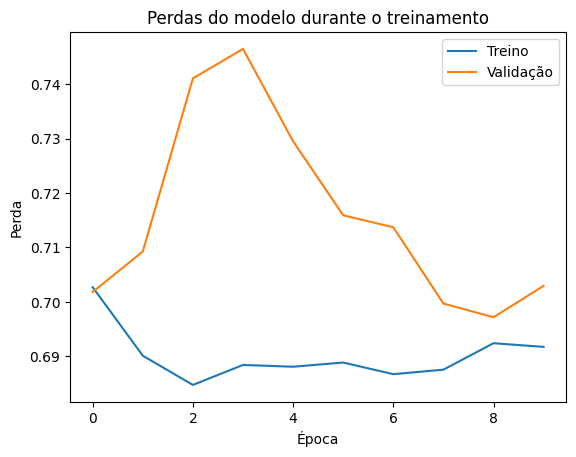

In [173]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdas do modelo durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treino','Validação']);

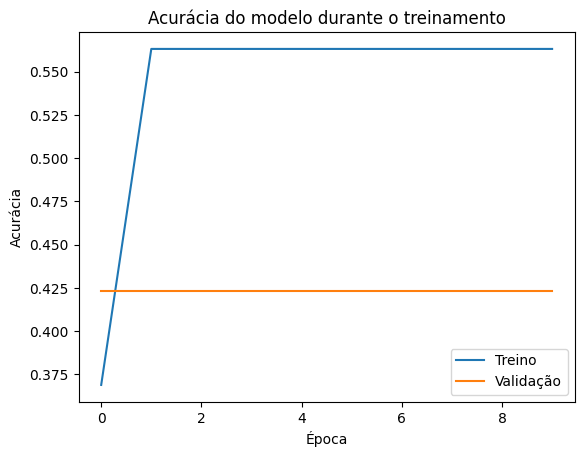

In [174]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treino','Validação']);